In [1]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [22]:

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
import glob
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error  
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score
import tensorflow as tf
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize']=15,5

import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
from sklearn.cluster import KMeans
#PCA
from sklearn.manifold import TSNE

In [23]:
seed=1899

In [24]:
df = pd.read_csv('Taguchi_ML_Data.csv', header=0, index_col=None)

In [25]:
df

,Temperature,Humidity,Thickness,G,Clay,Silt,Sand,LL,PL,PI,FSI (%),Tc (hours),Er (mg/hr),CIF
0,30,40,12,2.81,9,65,26,60,31,29,37,53,2258,4
1,50,90,12,2.81,9,65,26,60,31,29,37,32,1429,2
2,40,70,12,2.62,13,45,42,44,15,29,9,27,1165,15
3,50,90,12,2.81,9,65,26,60,31,29,37,42,1116,1
4,40,70,12,2.81,9,65,26,60,31,29,37,35,1312,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,30,70,4,2.50,82,8,10,305,140,165,870,49,562,45
158,50,40,4,2.60,78,12,10,212,147,65,200,4,791,2
159,30,70,4,2.50,82,8,10,305,140,165,870,62,411,20
160,50,40,4,2.50,82,8,10,305,140,165,870,4,791,14


In [260]:
idx=['Temperature', 'Humidity', 'Thickness', 'G', 'Clay', 'Silt', 'Sand', 'LL', 'PL', 'PI', 'FSI (%)', 'Er (mg/hr)','Tc (hours)']

In [269]:
newdf=df[idx]
data=newdf.values[:,:-1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
label=newdf.values[:,-1]
np.random.seed(seed)
Per=np.random.permutation(len(data))
data=data[Per]
label=label[Per]


In [270]:
data.shape

(162, 12)

In [271]:
data[0]

array([1.        , 0.        , 1.        , 0.17021277, 1.        ,
       0.        , 0.23809524, 1.        , 0.94852941, 1.        ,
       1.        , 0.28702993])

In [272]:
label[:50]

array([15.,  9.,  0., 43., 22., 18., 41., 22., 16., 30., 18.,  0., 16.,
        0., 30., 26., 28., 30.,  0.,  8., 14., 89., 25., 37., 66.,  8.,
       35., 36., 16., 40.,  0., 20., 44.,  0., 17., 34., 67., 24., 65.,
       18., 23., 10., 38., 10., 28., 47.,  0.,  0.,  0., 62.])

[0]
CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 12.9 µs


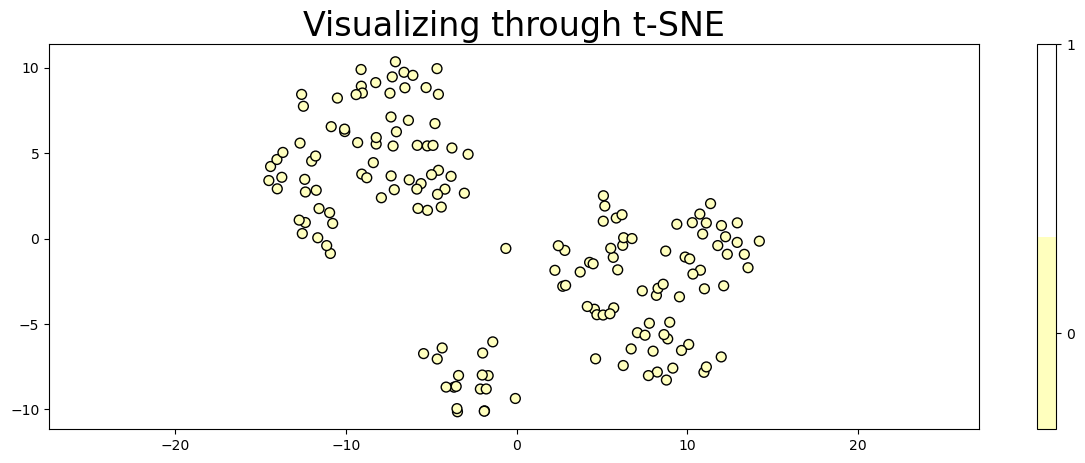

In [273]:
x_subset = data[:]
y_subset = [np.argmax(x) for x in label]

print(np.unique(y_subset))
x_subset=x_subset.reshape((x_subset.shape[0],x_subset.shape[1]))
%time
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)
plt.scatter(tsne[:, 0], tsne[:, 1], s= 50, c=y_subset, cmap='Spectral',edgecolors='black')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(2)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing through t-SNE', fontsize=24);

In [274]:
def MAPE(Y_actual,Y_Predicted):
    summ=0
    for i in range(len(Y_actual)):
        if Y_actual[i]!=0:
            summ+=np.abs((Y_actual[i] - Y_Predicted[i])/Y_actual[i])*100
        else:
            summ+=np.abs((Y_actual[i] - Y_Predicted[i]))*100
            
    mape = summ/len(Y_actual)
    return mape

def score(actual,predicted):
    mape=MAPE(actual,predicted)
    mse=mean_squared_error(actual,predicted)    
    rmse=math.sqrt(mse) 
    r2=r2_score(actual,predicted)
    return mse, rmse, mape[0],r2

In [275]:
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

In [276]:
input_lyr = Input(shape=(12,))
initializer = tf.keras.initializers.HeUniform()
layer1 = Dense(100, activation='relu',kernel_initializer=initializer)(input_lyr)
layer2 = Dense(500, activation='relu',kernel_initializer=initializer)(layer1)
layer3 = Dense(5000, activation='relu',kernel_initializer=initializer)(layer2)
# d11=Dropout(0.01)(layer3)
output_layer = Dense(1)(layer3)
model = Model(input_lyr, output_layer)

tf.random.set_seed(seed)
np.random.seed(seed)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_22 (Dense)            (None, 100)               1300      
                                                                 
 dense_23 (Dense)            (None, 500)               50500     
                                                                 
 dense_24 (Dense)            (None, 5000)              2505000   
                                                                 
 dense_25 (Dense)            (None, 1)                 5001      
                                                                 
Total params: 2,561,801
Trainable params: 2,561,801
Non-trainable params: 0
_________________________________________________________________


In [277]:
def CV(Train, TrainLabel,Test, TestLabel):
    
    callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1.0e-4, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
    history = model.fit(Train, TrainLabel, epochs=50000, batch_size=512,  validation_data=(Test, TestLabel), callbacks=[callback], shuffle=True)


    grd=[]
    gb=[]
    for i in range(len(data)):
        idx1=i
    #     print(idx1)
        inp = data[idx1:idx1+1]
        with tf.GradientTape() as tape:
            inputs = tf.cast(inp, tf.float32)
            tape.watch(inputs)
            outputs = model(inputs)[0]
            grads = tape.gradient(outputs,inputs)
            #Visualizing the back prop
            gb_viz =grads     
            gb_viz -= np.min(grads)
            gb_viz /= np.max(gb_viz)
            grd.append(grads)
            gb.append(gb_viz)

    GB=np.array(grd)
    GB=abs(GB)
    GBS=np.sum(GB,axis=0)[0]

    temp = GBS.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(GBS))
    print(GBS)
    print(ranks)
    newrank=10-ranks
    top=10
    newidx=[]
    
    for i in range(top):
        j=np.where(newrank==i)[0][0]
        newidx.append(idx[j])
        
    print()    
    print(newidx)
    
    return newidx


In [278]:
data.shape

(162, 12)

In [281]:
CV_result=[]
count=0
x=[ i for i in range(162)]
for i in range(10):
    y=[ k for k in range(count,count+16)]
    count+=16
#     print(y)
    z=[l for l in x if l not in y]
    Train=data[z]
    TrainLabel=label[z]
    Test=data[y]
    TestLabel=label[y]
    
    CV_result.append(CV(Train, TrainLabel,Test, TestLabel))

Epoch 1/50000
1/1 [==============================] - 0s 413ms/step - loss: 1307.5054 - val_loss: 337.2354
Epoch 2/50000
1/1 [==============================] - 0s 36ms/step - loss: 970.3152 - val_loss: 219.4925
Epoch 3/50000
1/1 [==============================] - 0s 33ms/step - loss: 726.5480 - val_loss: 216.3345
Epoch 4/50000
1/1 [==============================] - 0s 28ms/step - loss: 577.5791 - val_loss: 340.7402
Epoch 5/50000
1/1 [==============================] - 0s 27ms/step - loss: 538.4471 - val_loss: 527.6857
Epoch 6/50000
1/1 [==============================] - 0s 26ms/step - loss: 582.1689 - val_loss: 633.7330
Epoch 7/50000
1/1 [==============================] - 0s 26ms/step - loss: 616.0455 - val_loss: 619.9280
Epoch 8/50000
1/1 [==============================] - 0s 28ms/step - loss: 597.7454 - val_loss: 533.9875
Epoch 9/50000
1/1 [==============================] - 0s 27ms/step - loss: 548.2606 - val_loss: 429.5191
Epoch 10/50000
1/1 [==============================] - 0s 26ms/

1/1 [==============================] - 0s 27ms/step - loss: 224.1484 - val_loss: 286.3675
Epoch 80/50000
1/1 [==============================] - 0s 27ms/step - loss: 221.0807 - val_loss: 287.3699
Epoch 81/50000
1/1 [==============================] - 0s 28ms/step - loss: 217.9502 - val_loss: 289.0196
Epoch 82/50000
1/1 [==============================] - 0s 26ms/step - loss: 214.7753 - val_loss: 290.3334
Epoch 83/50000
1/1 [==============================] - 0s 27ms/step - loss: 211.5793 - val_loss: 291.0541
Epoch 84/50000
1/1 [==============================] - 0s 25ms/step - loss: 208.3793 - val_loss: 291.0363
Epoch 85/50000
1/1 [==============================] - 0s 26ms/step - loss: 205.1742 - val_loss: 290.9258
Epoch 86/50000
1/1 [==============================] - 0s 26ms/step - loss: 201.9654 - val_loss: 291.1755
Epoch 87/50000
1/1 [==============================] - 0s 26ms/step - loss: 198.7446 - val_loss: 292.1385
Epoch 88/50000
1/1 [==============================] - 0s 26ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 251.0590 - val_loss: 627.6390
Epoch 39/50000
1/1 [==============================] - 0s 25ms/step - loss: 248.2822 - val_loss: 627.3138
Epoch 40/50000
1/1 [==============================] - 0s 25ms/step - loss: 245.2284 - val_loss: 628.2307
Epoch 41/50000
1/1 [==============================] - 0s 25ms/step - loss: 242.2267 - val_loss: 627.2262
Epoch 42/50000
1/1 [==============================] - 0s 27ms/step - loss: 239.2912 - val_loss: 623.0118
Epoch 43/50000
1/1 [==============================] - 0s 25ms/step - loss: 236.1565 - val_loss: 616.7579
Epoch 44/50000
1/1 [==============================] - 0s 25ms/step - loss: 232.9574 - val_loss: 611.7413
Epoch 45/50000
1/1 [==============================] - 0s 27ms/step - loss: 229.7965 - val_loss: 609.5038
Epoch 46/50000
1/1 [==============================] - 0s 26ms/step - loss: 226.5073 - val_loss: 608.6267
Epoch 47/50000
1/1 [==============================] - 0s 26ms/step - l

Epoch 11/50000
1/1 [==============================] - 0s 25ms/step - loss: 323.2942 - val_loss: 371.6803
Epoch 12/50000
1/1 [==============================] - 0s 25ms/step - loss: 320.3976 - val_loss: 375.9135
Epoch 13/50000
1/1 [==============================] - 0s 26ms/step - loss: 317.5811 - val_loss: 380.9681
Epoch 14/50000
1/1 [==============================] - 0s 26ms/step - loss: 314.6641 - val_loss: 386.5967
Epoch 15/50000
1/1 [==============================] - 0s 25ms/step - loss: 311.7062 - val_loss: 392.0789
Epoch 16/50000
1/1 [==============================] - 0s 26ms/step - loss: 308.7465 - val_loss: 396.9800
Epoch 17/50000
1/1 [==============================] - 0s 25ms/step - loss: 305.8165 - val_loss: 401.1320
Epoch 18/50000
1/1 [==============================] - 0s 26ms/step - loss: 302.8512 - val_loss: 404.7019
Epoch 19/50000
1/1 [==============================] - 0s 27ms/step - loss: 299.8650 - val_loss: 408.1419
Epoch 20/50000
1/1 [==============================] - 0

1/1 [==============================] - 0s 26ms/step - loss: 89.8251 - val_loss: 650.0457
Epoch 90/50000
1/1 [==============================] - 0s 26ms/step - loss: 88.0440 - val_loss: 653.5608
Epoch 91/50000
1/1 [==============================] - 0s 25ms/step - loss: 87.0122 - val_loss: 640.5568
Epoch 92/50000
1/1 [==============================] - 0s 26ms/step - loss: 86.3282 - val_loss: 649.6241
Epoch 93/50000
1/1 [==============================] - 0s 27ms/step - loss: 85.3013 - val_loss: 632.3680
Epoch 94/50000
1/1 [==============================] - 0s 26ms/step - loss: 80.8189 - val_loss: 633.5066
Epoch 95/50000
1/1 [==============================] - 0s 26ms/step - loss: 76.9439 - val_loss: 635.4695
Epoch 96/50000
1/1 [==============================] - 0s 25ms/step - loss: 76.1986 - val_loss: 626.4745
Epoch 97/50000
1/1 [==============================] - 0s 26ms/step - loss: 76.2917 - val_loss: 637.6044
Epoch 98/50000
1/1 [==============================] - 0s 26ms/step - loss: 74.6

Epoch 62/50000
1/1 [==============================] - 0s 26ms/step - loss: 152.0246 - val_loss: 858.8925
Epoch 63/50000
1/1 [==============================] - 0s 25ms/step - loss: 148.9698 - val_loss: 866.5839
Epoch 64/50000
1/1 [==============================] - 0s 25ms/step - loss: 145.9101 - val_loss: 877.6759
Epoch 65/50000
1/1 [==============================] - 0s 25ms/step - loss: 142.8078 - val_loss: 889.9874
Epoch 66/50000
1/1 [==============================] - 0s 26ms/step - loss: 139.7213 - val_loss: 899.0402
Epoch 67/50000
1/1 [==============================] - 0s 26ms/step - loss: 136.6766 - val_loss: 908.8518
Epoch 68/50000
1/1 [==============================] - 0s 24ms/step - loss: 133.6677 - val_loss: 918.4318
Epoch 69/50000
1/1 [==============================] - 0s 26ms/step - loss: 130.6733 - val_loss: 927.0414
Epoch 70/50000
1/1 [==============================] - 0s 26ms/step - loss: 127.7790 - val_loss: 933.8224
Epoch 71/50000
1/1 [==============================] - 0

Epoch 34/50000
1/1 [==============================] - 0s 25ms/step - loss: 243.0711 - val_loss: 459.2179
Epoch 35/50000
1/1 [==============================] - 0s 26ms/step - loss: 240.2025 - val_loss: 461.8604
Epoch 36/50000
1/1 [==============================] - 0s 27ms/step - loss: 237.4012 - val_loss: 460.8533
Epoch 37/50000
1/1 [==============================] - 0s 27ms/step - loss: 234.4430 - val_loss: 457.1805
Epoch 38/50000
1/1 [==============================] - 0s 26ms/step - loss: 231.4423 - val_loss: 454.4099
Epoch 39/50000
1/1 [==============================] - 0s 27ms/step - loss: 228.5032 - val_loss: 454.7094
Epoch 40/50000
1/1 [==============================] - 0s 27ms/step - loss: 225.4441 - val_loss: 457.9832
Epoch 41/50000
1/1 [==============================] - 0s 26ms/step - loss: 222.3132 - val_loss: 461.3640
Epoch 42/50000
1/1 [==============================] - 0s 26ms/step - loss: 219.2268 - val_loss: 462.5370
Epoch 43/50000
1/1 [==============================] - 0

1/1 [==============================] - 0s 28ms/step - loss: 47.2408 - val_loss: 500.5300
Epoch 113/50000
1/1 [==============================] - 0s 27ms/step - loss: 45.9863 - val_loss: 483.0308
Epoch 114/50000
1/1 [==============================] - 0s 27ms/step - loss: 43.4696 - val_loss: 477.0685
Epoch 115/50000
1/1 [==============================] - 0s 27ms/step - loss: 43.6748 - val_loss: 503.0713
Epoch 116/50000
1/1 [==============================] - 0s 26ms/step - loss: 44.0479 - val_loss: 480.3322
Epoch 117/50000
1/1 [==============================] - 0s 32ms/step - loss: 42.1598 - val_loss: 487.0028
[2830.4966  1727.291   1862.7529   884.09863 2627.1138  2680.4177
  831.175    581.803    736.1144  1123.1378  2960.291   1479.2692 ]
[10  6  7  3  8  9  2  0  1  4 11  5]

['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
Epoch 1/50000
1/1 [==============================] - 0s 53ms/step - loss: 305.2544 - val_loss: 279.0630
Epoch 2/50000

Epoch 71/50000
1/1 [==============================] - 0s 27ms/step - loss: 70.7424 - val_loss: 775.1413
Epoch 72/50000
1/1 [==============================] - 0s 27ms/step - loss: 68.1891 - val_loss: 780.0873
Epoch 73/50000
1/1 [==============================] - 0s 27ms/step - loss: 65.7442 - val_loss: 783.1315
Epoch 74/50000
1/1 [==============================] - 0s 26ms/step - loss: 63.3561 - val_loss: 788.1055
Epoch 75/50000
1/1 [==============================] - 0s 26ms/step - loss: 61.0593 - val_loss: 790.1456
Epoch 76/50000
1/1 [==============================] - 0s 26ms/step - loss: 58.8835 - val_loss: 793.7599
Epoch 77/50000
1/1 [==============================] - 0s 25ms/step - loss: 56.7390 - val_loss: 799.5602
Epoch 78/50000
1/1 [==============================] - 0s 27ms/step - loss: 54.6829 - val_loss: 803.9430
Epoch 79/50000
1/1 [==============================] - 0s 26ms/step - loss: 52.7315 - val_loss: 806.8298
Epoch 80/50000
1/1 [==============================] - 0s 26ms/st

Epoch 46/50000
1/1 [==============================] - 0s 26ms/step - loss: 188.4250 - val_loss: 616.2035
Epoch 47/50000
1/1 [==============================] - 0s 26ms/step - loss: 185.7257 - val_loss: 620.3024
Epoch 48/50000
1/1 [==============================] - 0s 24ms/step - loss: 182.9966 - val_loss: 624.3907
Epoch 49/50000
1/1 [==============================] - 0s 26ms/step - loss: 180.2319 - val_loss: 627.8329
Epoch 50/50000
1/1 [==============================] - 0s 25ms/step - loss: 177.5022 - val_loss: 630.4775
Epoch 51/50000
1/1 [==============================] - 0s 25ms/step - loss: 174.7724 - val_loss: 633.3315
Epoch 52/50000
1/1 [==============================] - 0s 25ms/step - loss: 171.9870 - val_loss: 637.0903
Epoch 53/50000
1/1 [==============================] - 0s 25ms/step - loss: 169.1669 - val_loss: 641.8264
Epoch 54/50000
1/1 [==============================] - 0s 25ms/step - loss: 166.3699 - val_loss: 646.2321
Epoch 55/50000
1/1 [==============================] - 0

Epoch 21/50000
1/1 [==============================] - 0s 25ms/step - loss: 255.3366 - val_loss: 349.4306
Epoch 22/50000
1/1 [==============================] - 0s 25ms/step - loss: 252.4979 - val_loss: 351.2182
Epoch 23/50000
1/1 [==============================] - 0s 25ms/step - loss: 249.6144 - val_loss: 352.5214
Epoch 24/50000
1/1 [==============================] - 0s 26ms/step - loss: 246.7197 - val_loss: 353.7780
Epoch 25/50000
1/1 [==============================] - 0s 26ms/step - loss: 243.7665 - val_loss: 355.2216
Epoch 26/50000
1/1 [==============================] - 0s 26ms/step - loss: 240.8575 - val_loss: 356.7906
Epoch 27/50000
1/1 [==============================] - 0s 25ms/step - loss: 237.9162 - val_loss: 358.4031
Epoch 28/50000
1/1 [==============================] - 0s 25ms/step - loss: 234.9732 - val_loss: 360.0430
Epoch 29/50000
1/1 [==============================] - 0s 26ms/step - loss: 232.0184 - val_loss: 361.5773
Epoch 30/50000
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step - loss: 61.5505 - val_loss: 391.1060
Epoch 100/50000
1/1 [==============================] - 0s 25ms/step - loss: 71.6947 - val_loss: 395.2468
Epoch 101/50000
1/1 [==============================] - 0s 29ms/step - loss: 81.3762 - val_loss: 372.0909
[2912.4229  1726.4877  1867.9695   879.84247 2644.3704  2686.8125
  840.2976   595.523    743.3714  1119.4652  2973.1382  1529.8655 ]
[10  6  7  3  8  9  2  0  1  4 11  5]

['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
Epoch 1/50000
1/1 [==============================] - 0s 56ms/step - loss: 295.3886 - val_loss: 346.1299
Epoch 2/50000
1/1 [==============================] - 0s 27ms/step - loss: 298.9073 - val_loss: 353.5804
Epoch 3/50000
1/1 [==============================] - 0s 26ms/step - loss: 303.6375 - val_loss: 352.9238
Epoch 4/50000
1/1 [==============================] - 0s 26ms/step - loss: 297.7873 - val_loss: 353.3214
Epoch 5/50000
1/

Epoch 74/50000
1/1 [==============================] - 0s 27ms/step - loss: 84.1185 - val_loss: 716.8658
Epoch 75/50000
1/1 [==============================] - 0s 27ms/step - loss: 81.4417 - val_loss: 716.9512
Epoch 76/50000
1/1 [==============================] - 0s 25ms/step - loss: 78.8143 - val_loss: 716.8258
Epoch 77/50000
1/1 [==============================] - 0s 27ms/step - loss: 76.2207 - val_loss: 716.1787
Epoch 78/50000
1/1 [==============================] - 0s 28ms/step - loss: 73.6752 - val_loss: 714.1201
Epoch 79/50000
1/1 [==============================] - 0s 26ms/step - loss: 71.2435 - val_loss: 711.1352
Epoch 80/50000
1/1 [==============================] - 0s 26ms/step - loss: 68.8687 - val_loss: 708.8728
Epoch 81/50000
1/1 [==============================] - 0s 27ms/step - loss: 66.4753 - val_loss: 708.4081
Epoch 82/50000
1/1 [==============================] - 0s 25ms/step - loss: 64.0925 - val_loss: 707.1885
Epoch 83/50000
1/1 [==============================] - 0s 28ms/st

Epoch 49/50000
1/1 [==============================] - 0s 25ms/step - loss: 171.2876 - val_loss: 285.5616
Epoch 50/50000
1/1 [==============================] - 0s 24ms/step - loss: 167.4579 - val_loss: 285.8116
Epoch 51/50000
1/1 [==============================] - 0s 25ms/step - loss: 163.5629 - val_loss: 286.7080
Epoch 52/50000
1/1 [==============================] - 0s 26ms/step - loss: 159.7351 - val_loss: 288.7027
Epoch 53/50000
1/1 [==============================] - 0s 25ms/step - loss: 155.8659 - val_loss: 290.8195
Epoch 54/50000
1/1 [==============================] - 0s 25ms/step - loss: 152.0179 - val_loss: 291.8589
Epoch 55/50000
1/1 [==============================] - 0s 26ms/step - loss: 148.1738 - val_loss: 292.1494
Epoch 56/50000
1/1 [==============================] - 0s 25ms/step - loss: 144.3682 - val_loss: 293.2618
Epoch 57/50000
1/1 [==============================] - 0s 26ms/step - loss: 140.5638 - val_loss: 295.3680
Epoch 58/50000
1/1 [==============================] - 0

In [282]:
for x in CV_result:
    print(x)

['FSI (%)', 'Silt', 'Temperature', 'G', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'PL', 'Sand']
['FSI (%)', 'Temperature', 'Silt', 'G', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'PL', 'Sand']
['Clay', 'Temperature', 'Silt', 'G', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'PL', 'Sand']
['FSI (%)', 'Clay', 'Silt', 'Thickness', 'G', 'Humidity', 'Er (mg/hr)', 'PI', 'PL', 'Sand']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']
['Temperature', 'Silt', 'Clay', 'Thickness', 'Humidity', 'Er (mg/hr)', 'PI', 'G', 'Sand', 'PL']


3/3 [==============================] - 0s 7ms/step


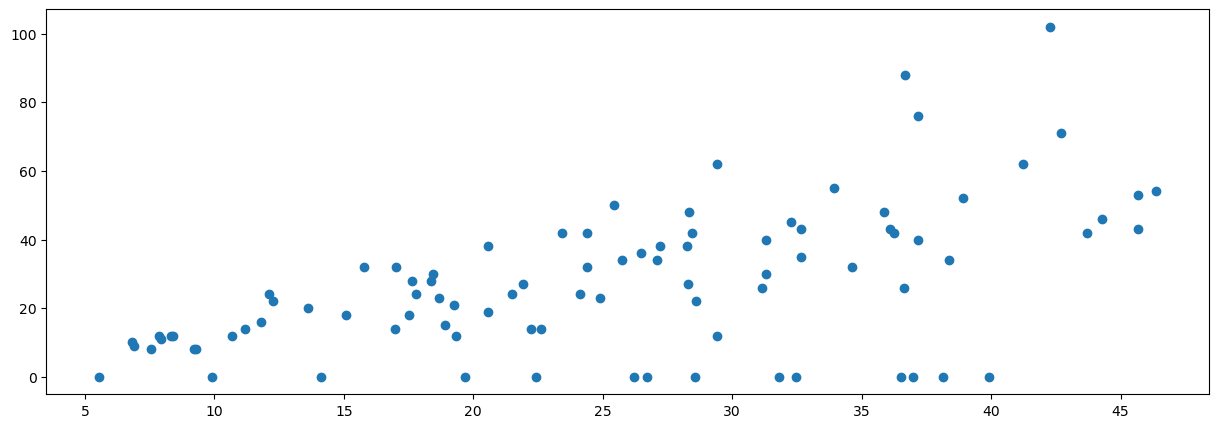

In [188]:
predict=model.predict(Train)
plt.scatter(predict,TrainLabel)

3/3 [==============================] - 0s 8ms/step


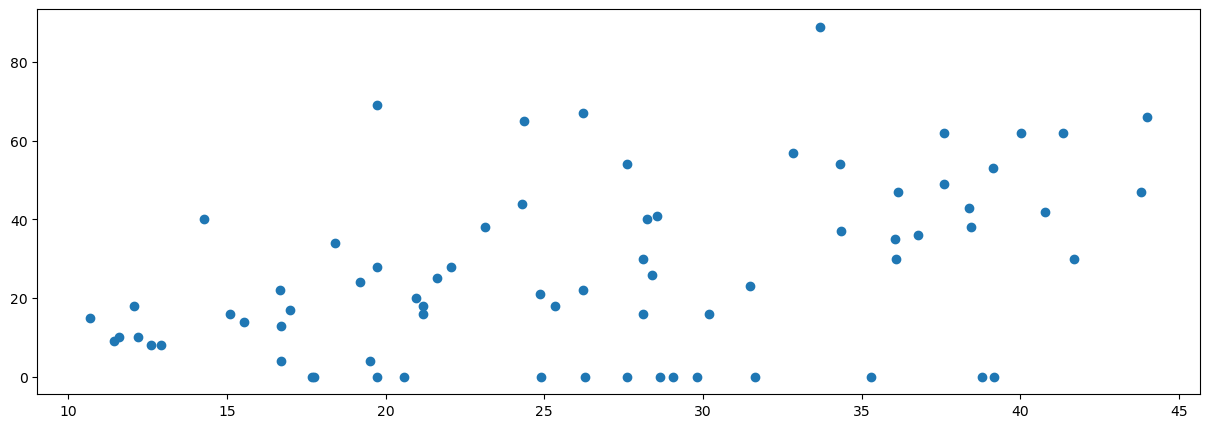

In [189]:
predictt=model.predict(Test)
plt.scatter(predictt,TestLabel)

In [190]:
score(TrainLabel,predict)

(302.5542026988137, 17.394085279163537, 434.04913, 0.3003071096903084)

In [191]:
score(TestLabel,predictt)

(382.3138994224833, 19.552848882515388, 570.7081, 0.20030276225858634)

In [164]:
# newidx=['Womc','SL','Phi','Clay','LL','Gamadmax','Wr','G','Mineral2','Sand']

In [314]:
newidx=['Temperature', 'Humidity', 'Thickness', 'Clay', 'Silt',  'Er (mg/hr)']

In [315]:
newidx

['Temperature', 'Humidity', 'Thickness', 'Clay', 'Silt']

In [316]:
newdf1=df[newidx]
data1=newdf1.values[:,:]
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(data1)
label1=df.values[:,-1]
np.random.seed(seed)
Per=np.random.permutation(len(data1))
data1=data1[Per]
label1=label1[Per]


In [317]:
kmeans = KMeans(5)
kmeans.fit(data1)
identified_clusters = kmeans.fit_predict(data1)
# identified_clusters

In [318]:
df.corr()

,Temperature,Humidity,Thickness,G,Clay,Silt,Sand,LL,PL,PI,FSI (%),Tc (hours),Er (mg/hr),CIF
Temperature,1.000000e+00,2.782539e-17,-4.493836e-17,4.244639e-02,-2.646236e-02,2.445031e-02,1.300837e-02,-1.240100e-02,-6.849257e-03,-1.683389e-02,-2.768336e-02,-0.419245,0.398471,-0.019031
Humidity,2.782539e-17,1.000000e+00,4.429174e-16,-4.872540e-02,-2.029225e-02,4.020234e-03,3.522579e-02,-5.437415e-03,-3.522095e-03,-6.633366e-03,1.736314e-02,0.041977,-0.388058,0.021566
Thickness,-4.493836e-17,4.429174e-16,1.000000e+00,-2.929305e-15,-1.738212e-16,-6.144168e-16,7.054946e-18,-8.427078e-17,3.079858e-16,-3.130980e-16,5.492194e-17,0.096021,0.075181,-0.246897
G,4.244639e-02,-4.872540e-02,-2.929305e-15,1.000000e+00,-6.460605e-01,6.903078e-01,1.575233e-01,-4.042786e-01,-3.331620e-01,-4.477202e-01,-3.461398e-01,0.003652,0.240076,-0.114127
Clay,-2.646236e-02,-2.029225e-02,-1.738212e-16,-6.460605e-01,1.000000e+00,-8.778156e-01,-5.706960e-01,6.551872e-01,6.137709e-01,6.485466e-01,5.779091e-01,-0.020544,-0.317566,0.224345
Silt,2.445031e-02,4.020234e-03,-6.144168e-16,6.903078e-01,-8.778156e-01,1.000000e+00,1.076306e-01,-7.102751e-01,-6.691775e-01,-6.992388e-01,-6.344813e-01,0.045393,0.316399,-0.220309
Sand,1.300837e-02,3.522579e-02,7.054946e-18,1.575233e-01,-5.706960e-01,1.076306e-01,1.000000e+00,-1.422357e-01,-1.267283e-01,-1.473725e-01,-1.117756e-01,-0.035178,0.116715,-0.087960
LL,-1.240100e-02,-5.437415e-03,-8.427078e-17,-4.042786e-01,6.551872e-01,-7.102751e-01,-1.422357e-01,1.000000e+00,9.643417e-01,9.609755e-01,9.367516e-01,0.013554,-0.356682,0.311188
PL,-6.849257e-03,-3.522095e-03,3.079858e-16,-3.331620e-01,6.137709e-01,-6.691775e-01,-1.267283e-01,9.643417e-01,1.000000e+00,8.534994e-01,8.380317e-01,0.019905,-0.355343,0.283880
PI,-1.683389e-02,-6.633366e-03,-3.130980e-16,-4.477202e-01,6.485466e-01,-6.992388e-01,-1.473725e-01,9.609755e-01,8.534994e-01,1.000000e+00,9.683822e-01,0.005740,-0.330540,0.316482


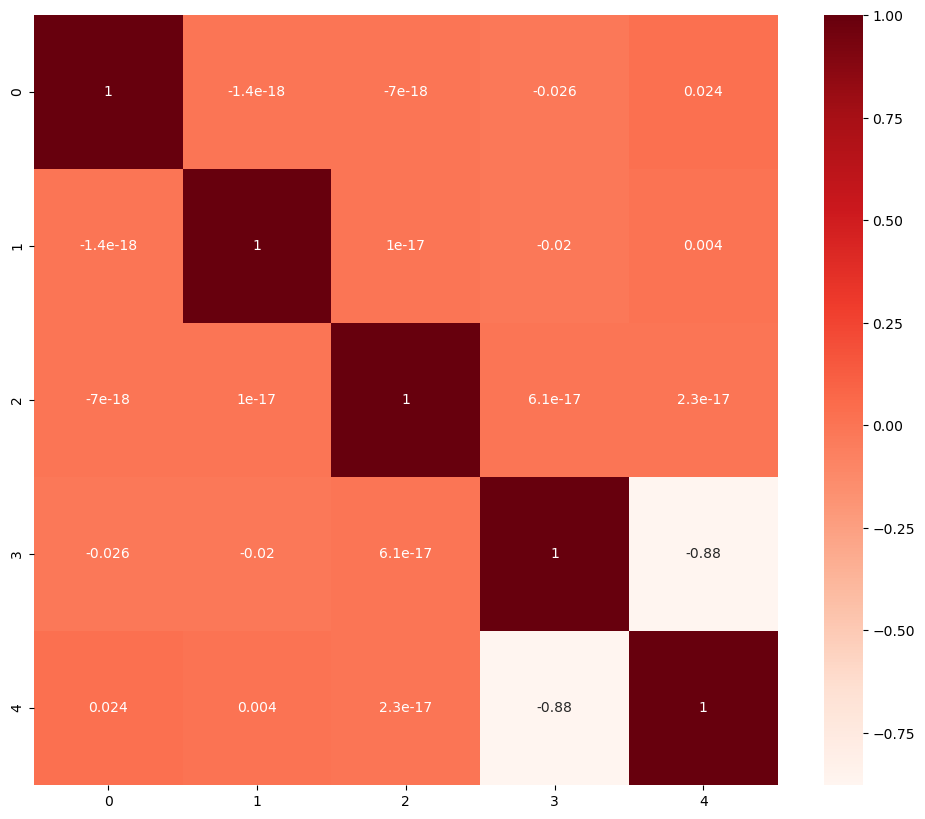

In [319]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
ff1 = pd.DataFrame(data1)
cor = ff1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [320]:
count=[i for i in range(5)]
cls = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
Train1,Test1=[],[]
TrainLabel1, TestLabel1=[],[]
Trainclass1, Testclass1=[],[]
for i in range(len(data1)):
    x=identified_clusters[i]
    if x==0 and count[0] < 16:
        count[0]+=1
        Test1.append(data1[i])
        TestLabel1.append(label1[i])
        Testclass1.append(cls[x])
    elif x==1 and count[1] < 16:
        count[1]+=1
        Test1.append(data1[i])
        TestLabel1.append(label1[i])
        Testclass1.append(cls[x])
    elif x==2 and count[2] < 16:
        count[2]+=1
        Test1.append(data1[i])
        TestLabel1.append(label1[i])
        Testclass1.append(cls[x])
    elif x==3 and count[3] < 17:
        count[3]+=1
        Test1.append(data1[i])
        TestLabel1.append(label1[i])
        Testclass1.append(cls[x])
    elif x==4 and count[4] < 17:
        count[4]+=1
        Test1.append(data1[i])
        TestLabel1.append(label1[i])
        Testclass1.append(cls[x])
    else:
        Train1.append(data1[i])
        TrainLabel1.append(label1[i])
        Trainclass1.append(cls[x])
        
Train1=np.array(Train1)
Test1=np.array(Test1)
TrainLabel1=np.array(TrainLabel1)
TestLabel1=np.array(TestLabel1)
Trainclass1=np.array(Trainclass1)
Testclass1=np.array(Testclass1)

In [322]:
top=5

In [323]:
input_lyr1 = Input(shape=(top,))
initializer1 = tf.keras.initializers.HeUniform()
layer11 = Dense(100, activation='relu',kernel_initializer=initializer1)(input_lyr1)
layer21 = Dense(500, activation='relu',kernel_initializer=initializer1)(layer11)
layer31 = Dense(5000, activation='relu',kernel_initializer=initializer1)(layer21)
# d1=Dropout(0.01)(layer31)
output_layer1 = Dense(1)(layer31)
model1 = Model(input_lyr1, output_layer1)

tf.random.set_seed(seed)
np.random.seed(seed)
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_34 (Dense)            (None, 100)               600       
                                                                 
 dense_35 (Dense)            (None, 500)               50500     
                                                                 
 dense_36 (Dense)            (None, 5000)              2505000   
                                                                 
 dense_37 (Dense)            (None, 1)                 5001      
                                                                 
Total params: 2,561,101
Trainable params: 2,561,101
Non-trainable params: 0
_________________________________________________________________


In [324]:
Train1.shape

(90, 5)

In [325]:
callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1.0e-4, patience=50, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
history = model1.fit(Train1, TrainLabel1, epochs=50000, batch_size=512,  validation_data=(Test1, TestLabel1), callbacks=[callback], shuffle=True)


Epoch 1/50000
1/1 [==============================] - 0s 291ms/step - loss: 129.8601 - val_loss: 56.4057
Epoch 2/50000
1/1 [==============================] - 0s 27ms/step - loss: 70.8146 - val_loss: 76.6881
Epoch 3/50000
1/1 [==============================] - 0s 28ms/step - loss: 97.4069 - val_loss: 60.4147
Epoch 4/50000
1/1 [==============================] - 0s 30ms/step - loss: 75.0296 - val_loss: 45.0803
Epoch 5/50000
1/1 [==============================] - 0s 33ms/step - loss: 54.4884 - val_loss: 44.5533
Epoch 6/50000
1/1 [==============================] - 0s 26ms/step - loss: 52.8550 - val_loss: 49.1981
Epoch 7/50000
1/1 [==============================] - 0s 26ms/step - loss: 58.4762 - val_loss: 49.0667
Epoch 8/50000
1/1 [==============================] - 0s 32ms/step - loss: 58.9351 - val_loss: 43.6278
Epoch 9/50000
1/1 [==============================] - 0s 32ms/step - loss: 52.8425 - val_loss: 38.2200
Epoch 10/50000
1/1 [==============================] - 0s 31ms/step - loss: 45.76

In [326]:
top

5

In [327]:
Train1.shape

(90, 5)

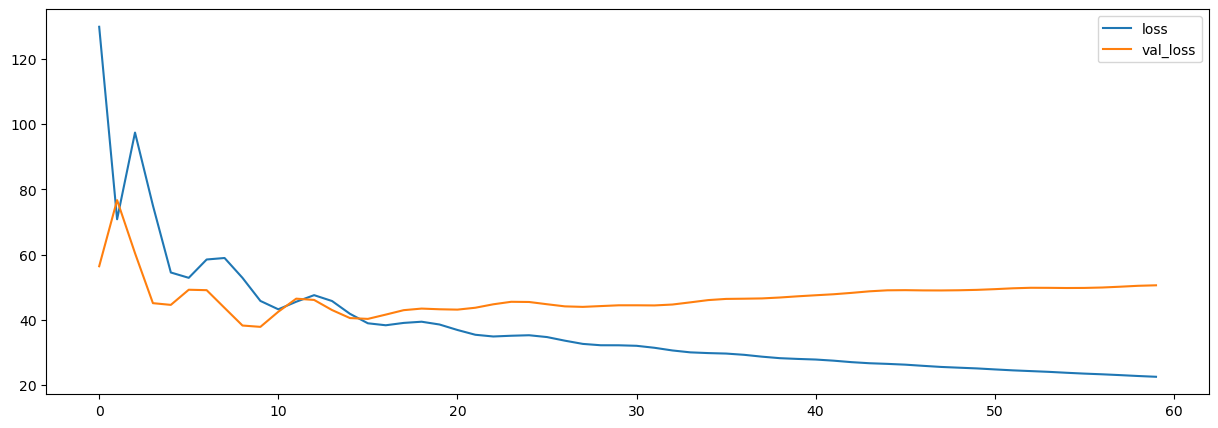

In [328]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

3/3 [==============================] - 0s 8ms/step


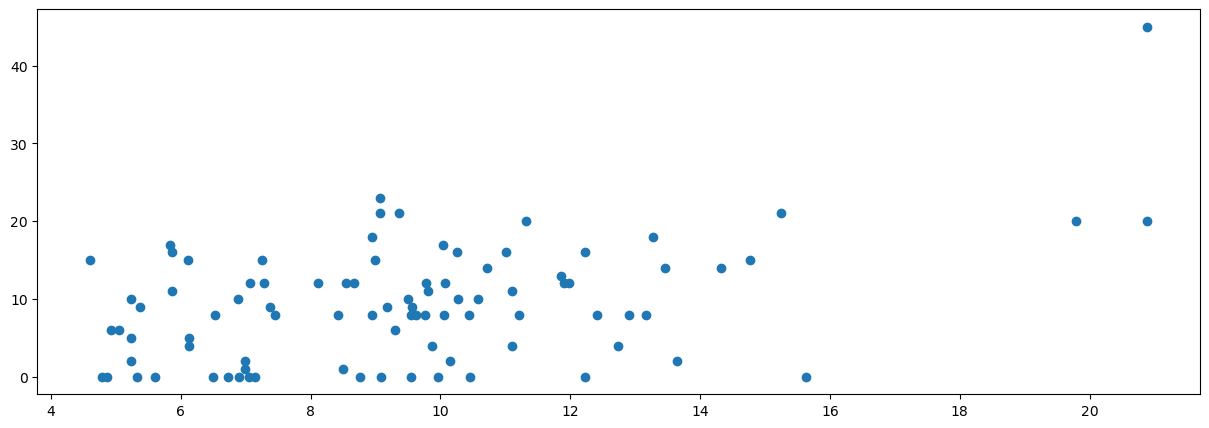

In [329]:
predict1=model1.predict(Train1)
plt.scatter(predict1,TrainLabel1)

3/3 [==============================] - 0s 9ms/step


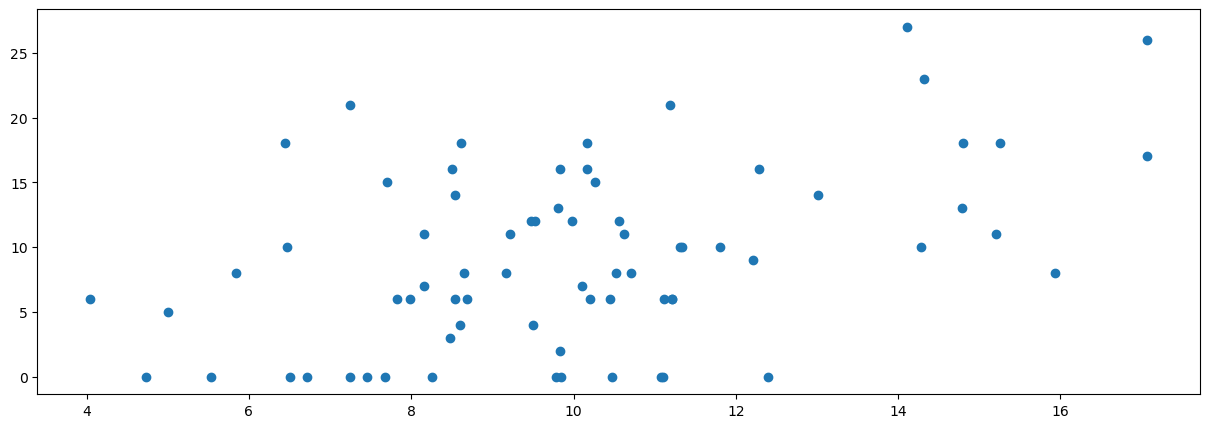

In [330]:
predict2=model1.predict(Test1)
plt.scatter(predict2,TestLabel1)

In [331]:
score(TrainLabel1,predict1)

(43.19504997943673, 6.572294118451846, 202.43384, 0.21048852596480372)

In [332]:
score(TestLabel1,predict2)

(37.81103134248253, 6.149067518126836, 203.01639, 0.18938833090952556)

In [136]:
score(TrainLabel,predict1)

(4522.604157752105, 67.25030972235075, 56.24505370334686, 0.9391860552456823)

In [137]:
score(TestLabel,predict2)

(4752.8853203125145, 68.94117289626362, 55.555570746160235, 0.9396303676105079)